## A simple swarm

In [1]:
%load_ext autoreload 
%autoreload 2
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

In [2]:
from core.agent import *
from core.world import * 
from dynamics.space.resource_map import *
from core.render import * 
from core.env_params import * 
from core.skill import * 
from core.models import *
from core.env_params import *
from core.message import *

pygame-ce 2.4.1 (SDL 2.28.5, Python 3.11.9)


In [3]:
from dynamics.agents.sar_agent import *
from dynamics.agents.trade_agent import * 
from dynamics.world.sar_world import *
from dynamics.models.util_sampler import *

def initialize_swarm(world : BaseWorld):
    swarm = [SARAgent() for i in range(SWARM_SIZE)]
    # skill_initializer = DefaultSkillInitializer(num_skills = PRODUCT_TYPES)
    utility_initializer = UtilitySampler()

    for agent in swarm:
        # skill_initializer.forward(agent)
        utility_initializer.forward(agent)
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)


In [4]:

from urban.urban_gen import * 
from dynamics.models.victims import * 
from urban.sar_comm import * 

terrain_generator = UrbanTerrainMapGenerator(padding = MAX_VISIBILITY)
victim_generator = VictimGenerator(padding = MAX_VISIBILITY)
def initialize_terrain(world : BaseWorld):
    terrain_map, population_map = terrain_generator.generate(world._dims)
    map_collection : BaseMapCollection = BaseMapCollection()
    map_collection.add_map("Terrain", terrain_map)
    map_collection.add_map("Population", population_map)

    victim_generator.set_density_map(population_map)
    victim_map = victim_generator.generate(world._dims)

    map_collection.add_map("Victims", victim_map)
    return map_collection


In [5]:
from dynamics.models.energy import EnergyModel
world = SARWorld(dims = WORLD_DIMS,
              swarm_initializer= initialize_swarm,
              generation_pipeline=initialize_terrain
              )
world.add_model("energy_model", EnergyModel())
world.reset()

comms_protocol = SARCommunicationProtocol()

NameError: name 'UtilitySampler' is not defined

In [6]:
# Test movements by doing random actions
def update():
    world.update()
    # Evaluate the agent's utility
    for agent in world.agents:
        agent.calculate_utility()


    for agent in world.agents:
        action_choice = np.random.randint(0, 5)
        choice = np.random.randint(1, 5)

        match (action_choice): 
            case 1: agent.move(choice)
            # case 2: agent.pick_up(choice)
            # case 3: agent.put_down(choice)
            # case 4: 
                # prod_to_make = np.random.randint(RESOURCE_TYPES + 1, RESOURCE_TYPES + PRODUCT_TYPES + 1)
                # agent.make(prod_to_make)
            #     pass
    
    comms_protocol.send_messages(world)
    comms_protocol.receive_messages(world)


update()

In [7]:
render_world(world, (800, 800), update_fn=update, delay_s=0)

# Data Visualization

## Social Network 

In [8]:
network = nx.graph.Graph()

for agent in world.agents:
    for neighbor in agent._current_state.relations:
        network.add_edge(agent.id, neighbor, weight = agent._current_state.relations[neighbor])

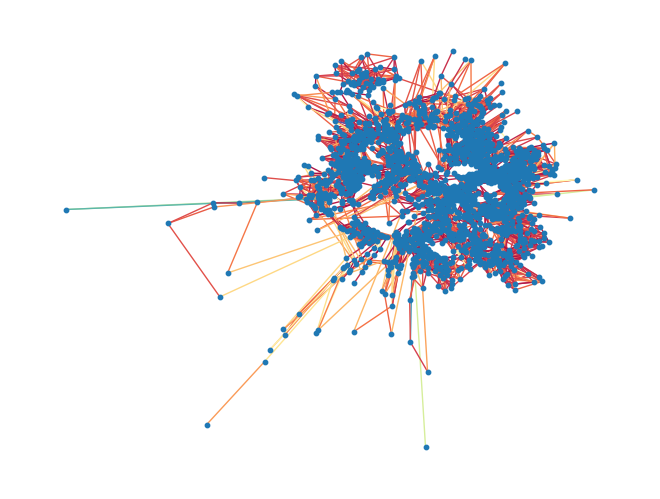

In [9]:
edges,weights = zip(*nx.get_edge_attributes(network ,'weight').items())
nx.draw_kamada_kawai(network, node_size = 10, edge_color = weights, edge_cmap = plt.cm.Spectral)

## Economy

In [ ]:
resources : dict[int, int]  = {}
for agent in world.agents: 
    inventory = agent._current_state.inventory
    for t, q in inventory.items():
        if not t in resources: 
            resources[t] = 0
        resources[t] += q

resource_types = list(resources.keys())
quantities = list(resources.values())

plt.bar(resource_types, quantities)
plt.xlabel('Resource Type')
plt.ylabel('Quantity')
plt.title('Resource Distribution')
plt.show()

## Utility

In [ ]:
utilities = []
for agent in world.agents: 
    utilities.append(agent.utility)


plt.hist(utilities, 50)
plt.title('Agent Happiness')
plt.show()

# Verify certain things about the simulation

In [67]:
swarm = world.agents

In [ ]:
# Validate the observation space provided is sensible
obs = swarm[123].local_observation

print(obs.nearby_agents, obs.nearby_agents.shape)
print(obs.resource_types, obs.resource_types.shape)

In [68]:
# Validate that all observation spaces are square
for agent in swarm: 
    obs = agent.local_observation
    if (obs.resource_types.shape[0] != obs.resource_types.shape[1]):
        print(agent.current_position_const, obs.resource_types.shape)

In [ ]:
# Validate that all swarm agents landed in different positions
positions = set()
for agent in swarm:
    pos = agent.current_position
    positions.add((pos[0], pos[1]))

print(len(positions), len(world.agents))

In [ ]:
# Check for resources
rsrc_qty = world._resource_map._resource_quantity_map
qtys = []

for i in range(rsrc_qty.shape[0]):
    for j in range(rsrc_qty.shape[1]):
        if rsrc_qty[i, j] > 0:
            qtys.append(rsrc_qty[i, j])

print(qtys)

In [ ]:
# Check for agent state
state = swarm[124]._current_state
print(state.inventory, state.current_utility)


# Perftest

In [287]:
import cProfile
def stress_test():
    np.random.seed(42)
    world.reset()
    for _ in range(0, 1000):
        update()

In [ ]:

cProfile.run('stress_test()', sort = 'time')

In [ ]:
cProfile.run('world.update()', sort = 'time')